# Using ICTP to train machine-learned interatomic potentials based on higher-rank irreducible Cartesian tensors and run molecular dynamics simulations

This notebook demonstrates how machine-learned interatomic potentials, as implemented in ICTP, can be trained with publicly available benchmark data sets and then employed in molecular dynamics simulations. In particular, we use the DHA molecule from the [MD22 data set](http://www.sgdml.org) and the [Ta-V-Cr-W data set](https://doi.org/10.18419/darus-3516). We begin by downloading and storing the corresponding data sets. We store them in the `../datasets` subfolder. For the [Ta-V-Cr-W data set](https://doi.org/10.18419/darus-3516), we have to run `python prepare_extxyz.py` and `python prepare_deformed_experiments.py` in the `../datasets/HEA` subfolder before launching the training of ICTP models. In the next step, we load all necessary modules and prepare scripts for training and testing our models. Training, evaluation, and molecular dynamics simulations may require a few hours. Therefore, we provide separate scripts: `run_training_DHA.py`, `run_molecular_dynamics_DHA.py`, `run_training_HEA.py`, and `run_molecular_dynamics_HEA.py` to simplify the process. In the following, we explain the main building blocks and present the results of the respective steps.

In [1]:
import sys

# set python paths
sys.path.append('/mnt/local/vzaverkin/projects/ictp')

from typing import Optional, Union, Dict, Tuple
from pathlib import Path
import yaml

import numpy as np

from ictp.data.data import AtomicStructures

from ictp.strategies import TrainingStrategy, EvaluationStrategy

from ictp.model.forward import load_model_from_folder

from ictp.utils.config import update_config
from ictp.utils.misc import set_default_dtype, load_object

import matplotlib.pylab as plt
from ase.io.trajectory import Trajectory

from scipy import signal

axis_font = { 'size':'12'}

The training and evaluation can be performed using the `TrainingStrategy` and `EvaluationStrategy`, respectively, and we define the following functions to make the process simpler:

In [2]:
# training
def train(config: Optional[Union[str, Dict]] = None):
    
    # load config from config_file
    if isinstance(config, str):
        config = yaml.safe_load(Path(config).read_text())

    # update default config with provided parameters (is done twice as here we need to update data path)
    config = update_config(config)
    
    # define default dtype
    set_default_dtype(config['default_dtype'])
    
    # manage data
    if config['data_path']:
        atomic_structures = AtomicStructures.from_file(config['data_path'], **config)
        split = atomic_structures.random_split({'train': config['n_train'], 'valid': config['n_valid']},
                                               seed=config['data_seed'])
    else:
        train_structures = AtomicStructures.from_file(config['train_data_path'], **config)
        valid_structures = AtomicStructures.from_file(config['valid_data_path'], **config)
        split = {'train': train_structures, 'valid': valid_structures}

    # run training
    training = TrainingStrategy(config)
    _ = training.run(train_structures=split['train'], valid_structures=split['valid'], folder=config['model_path'])

In [3]:
# evaluation
def eval(config: Optional[Union[str, Dict]] = None):

    # load config from config_file
    if isinstance(config, str):
        config = yaml.safe_load(Path(config).read_text())

    # update default config with provided parameters (is done twice as here we need to update data path)
    config = update_config(config)
    
    # define default dtype
    set_default_dtype(config['default_dtype'])

    # manage data
    if config['data_path']:
        atomic_structures = AtomicStructures.from_file(config['data_path'], **config)
        split = atomic_structures.random_split({'train': config['n_train'], 'valid': config['n_valid']},
                                               seed=config['data_seed'])
        if 'test' not in split:
            raise RuntimeError(f'Current split does not contain test data. In this case make sure to provide '
                               f'a separate test data path.')
        test_structures = split['test']
    else:
        test_structures = AtomicStructures.from_file(config['test_data_path'], **config)

    # load trained models and evaluate them on the test set
    model = load_model_from_folder(config['model_path'], key='best')
    
    evaluate = EvaluationStrategy(config)
    errors = evaluate.run(model, test_structures=test_structures, folder=config['model_path'])
    return errors

Then, we can define configurations for the corresponding DHA and Ta-V-Cr-W systems:

In [4]:
config_DHA = dict(data_path='../datasets/md22/md22_DHA.xyz',
                  device='cuda:0',
                  data_seed=0,
                  atomic_types=['H', 'C', 'N', 'O'],
                  atomic_energies=[0., 0., 0., 0.],
                  r_cutoff=6.0,
                  n_train=500,
                  n_valid=50,
                  train_batch_size=32,
                  eval_batch_size=50,
                  model_path='../results/md22_DHA/seed_0',
                  model_seed=0,
                  default_dtype='float32',
                  n_hidden_feats=128,
                  n_product_feats=128,
                  n_interactions=2,
                  l_max_hidden_feats=1,
                  l_max_edge_attrs=3,
                  correlation=3,
                  coupled_product_feats=False,
                  symmetric_product=True,
                  max_epoch=1000,
                  scheduler_patience=50,
                  ema=True,
                  ema_decay=0.99,
                  train_loss={
                      'type': 'weighted_sum',
                      'losses': [
                          {'type': 'energy_by_sqrt_atoms_sse'},
                          {'type': 'forces_sse'}
                          ],
                      'weights': [
                          10.0 / 23.06 ** 2,
                          1.0 / 23.06 ** 2
                          ]
                      },
                  early_stopping_loss={
                      'type': 'weighted_sum',
                      'losses': [
                          {'type': 'energy_by_sqrt_atoms_sse'},
                          {'type': 'forces_sse'}
                          ],
                      'weights': [
                          10.0 / 23.06 ** 2,
                          1.0/ 23.06 ** 2
                          ]
                      },
                  eval_losses=[
                      {'type': 'energy_per_atom_rmse'},
                      {'type': 'energy_per_atom_mae'},
                      {'type': 'forces_rmse'},
                      {'type': 'forces_mae'}
                      ]
                  )

In [5]:
config_HEA = dict(train_data_path=f'../datasets/HEA/train_cfgs_0.extxyz',
                  valid_data_path=f'../datasets/HEA/valid_cfgs_0.extxyz',
                  device='cuda:0',
                  data_seed=0,
                  atomic_types=['Ta', 'V', 'Cr', 'W'],
                  atomic_energies=[0., 0., 0., 0.],
                  r_cutoff=5.0,
                  n_train=4873,
                  n_valid=500,
                  train_batch_size=32,
                  eval_batch_size=100,
                  model_path=f'../results/HEA/seed_0',
                  model_seed=0,
                  default_dtype='float32',
                  n_hidden_feats=32,
                  n_product_feats=32,
                  n_interactions=2,
                  l_max_hidden_feats=1,
                  l_max_edge_attrs=2,
                  correlation=2,
                  coupled_product_feats=False,
                  symmetric_product=True,
                  max_epoch=1000,
                  scheduler_patience=50,
                  lr=0.01,
                  ema=True,
                  ema_decay=0.99,
                  train_loss={
                      'type': 'weighted_sum',
                      'losses': [
                          {'type': 'energy_by_sqrt_atoms_sse'},
                          {'type': 'forces_sse'},
                          {'type': 'virials_by_sqrt_atoms_sse'}
                          ],
                      'weights': [
                          1.0,
                          0.01,
                          0.001
                          ]
                      },
                  early_stopping_loss={
                      'type': 'weighted_sum',
                      'losses': [
                          {'type': 'energy_by_sqrt_atoms_sse'},
                          {'type': 'forces_sse'},
                          {'type': 'virials_by_sqrt_atoms_sse'}
                          ],
                      'weights': [
                          1.0,
                          0.01,
                          0.001
                          ]
                      },
                  eval_losses=[
                      {'type': 'energy_per_atom_rmse'},
                      {'type': 'energy_per_atom_mae'},
                      {'type': 'forces_rmse'},
                      {'type': 'forces_mae'},
                      {'type': 'virials_per_atom_rmse'},
                      {'type': 'virials_per_atom_mae'}
                      ]
                  )

The most critical hyper-parameters are `n_hidden_feats`, `n_product_feats`, `n_interactions`, `l_max_hidden_feats`, `l_max_edge_attrs`, `correlation`, and the relative weights of the corresponding loss functions in `train_loss` and `early_stopping_loss`. `n_hidden_feats` and `n_product_feats` define the number of hidden feature channels and those used for constructing the product basis, respectively. `n_interactions` define the number of message-passing layers, while `l_max_hidden_feats` is the maximal rank of the employed messages, `l_max_edge_attrs` denotes the maximal rank of Cartesian tensors employed in embedding atomic environments, and `correlation` defines the correlation-order in the product basis of a single message-passing layer. For more details on the hyper-parameters, we refer to the docstrings for the respective classes. Now, we are ready to train our models and can use the prepared script for this. We can, e.g., run `python run_training_DHA.py > dha.out 2> dha.err` and `python run_training_HEA.py > hea.out 2> hea.err`, respectively. The corresponding results are:

In [6]:
RESULTS_PATH = Path('../results')

In [7]:
# DHA
energy_rmse = load_object(RESULTS_PATH / 'md22_DHA/seed_0/test_results.json', use_json=True)['energy_per_atom_rmse'] / 23.06 * 1000
force_rmse = load_object(RESULTS_PATH / 'md22_DHA/seed_0/test_results.json', use_json=True)['forces_rmse'] / 23.06

print('-----------------------')
print(f'energy_mae = {np.round(energy_rmse, 2)} meV/atom')
print(f'force_mae = {np.round(force_rmse, 3)} eV/Angstrom')

-----------------------
energy_mae = 0.37 meV/atom
force_mae = 0.02 eV/Angstrom


In [8]:
# HEA
results = {}

for task_name in ['4comp', 'CrW', 'TaCr', 'TaV', 'TaW', 'VCr', 'VW', 'noCr', 'noTa', 'noV', 'noW', 'total_md']:
    results[task_name] = {}
    results[task_name]['energy_rmse'] = load_object(RESULTS_PATH / f'HEA/seed_0/results_{task_name}.test_0.json', use_json=True)['energy_per_atom_rmse'] * 1000
    results[task_name]['forces_rmse'] = load_object(RESULTS_PATH / f'HEA/seed_0/results_{task_name}.test_0.json', use_json=True)['forces_rmse']

print('-----------------------')
for task_name in results.keys():
    print(task_name, np.round(results[task_name]['energy_rmse'], 2), 'meV/atom')

print('-----------------------')
for task_name in results.keys():
    print(task_name, np.round(results[task_name]['forces_rmse'], 3), 'eV/Angstrom')

results_deformed = {}

for task_name in ['TaV', 'TaCr', 'TaW', 'VCr', 'VW', 'CrW']:
    results_deformed[task_name] = {}
    results_deformed[task_name]['energy_rmse'] = load_object(RESULTS_PATH / f'HEA/seed_0/results_deformed_{task_name}.json', use_json=True)['energy_per_atom_rmse'] * 1000
    results_deformed[task_name]['forces_rmse'] = load_object(RESULTS_PATH / f'HEA/seed_0/results_deformed_{task_name}.json', use_json=True)['forces_rmse']
    
print('-----------------------')
for task_name in results_deformed.keys():
    print(task_name, np.round(results_deformed[task_name]['energy_rmse'], 2), 'meV/atom')

-----------------------
4comp 1.26 meV/atom
CrW 6.85 meV/atom
TaCr 3.16 meV/atom
TaV 1.18 meV/atom
TaW 1.93 meV/atom
VCr 1.33 meV/atom
VW 1.69 meV/atom
noCr 0.99 meV/atom
noTa 1.05 meV/atom
noV 2.03 meV/atom
noW 1.08 meV/atom
total_md 2.12 meV/atom
-----------------------
4comp 0.028 eV/Angstrom
CrW 0.024 eV/Angstrom
TaCr 0.03 eV/Angstrom
TaV 0.022 eV/Angstrom
TaW 0.019 eV/Angstrom
VCr 0.019 eV/Angstrom
VW 0.02 eV/Angstrom
noCr 0.025 eV/Angstrom
noTa 0.023 eV/Angstrom
noV 0.026 eV/Angstrom
noW 0.031 eV/Angstrom
total_md 0.151 eV/Angstrom
-----------------------
TaV 4.17 meV/atom
TaCr 0.54 meV/atom
TaW 0.7 meV/atom
VCr 4.12 meV/atom
VW 0.76 meV/atom
CrW 2.36 meV/atom


Having trained ICTP potentials, we can now run molecular dynamics simulations. For DHA, we have chosen to run molecular dynamics simulations in the canonical (NVT) statistical ensemble and compute the power spectrum:

In [9]:
def vel_correlate(vel: np.ndarray) -> np.ndarray:
    # computes velocity (auto-)correlation function
    traj_len = vel.shape[0]
    n_atoms = vel.shape[1]
    vel_mean = np.mean(vel, axis=0)
    vel -= vel_mean
    vel_acf = np.zeros((traj_len, ), dtype=float)
    for ii in range(n_atoms):
        for jj in range(3):
            vel_acf_ij = signal.fftconvolve(vel[:, ii, jj], vel[::-1, ii, jj], 'full')
            vel_acf += vel_acf_ij[len(vel_acf_ij) // 2:]
    return vel_acf / (traj_len * n_atoms * 3)

In [10]:
def fft_acf(acf: np.ndarray, dt: float, lam: float = 5., len_factor: float = 1.) -> Tuple[np.ndarray, np.ndarray]:
    time = np.arange(len(acf)) * dt
    decay = np.exp(-lam * (time / time[-1]) ** 2)
    acf *= decay
    acf = np.pad(acf, pad_width=(0, int(len_factor*len(acf))), mode='constant')
    fft = np.fft.fft(acf).real * dt
    freq = np.fft.fftfreq(len(acf), d=dt) * 1.0 / (2.99792458 * 10 ** 10)
    return fft[:len(fft)//2], freq[:len(fft)//2]

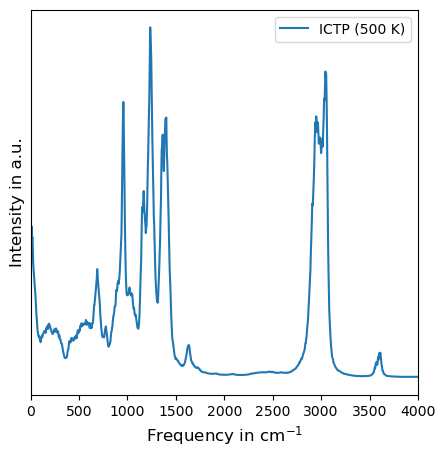

In [11]:
# time step
dt = 0.5 * 10 ** (-15)

# read trajectory
traj = Trajectory("dha-nvt.traj")[20000:]

# read velocities
v = np.zeros((len(traj),len(traj[0]), 3))
for i in range(len(traj)):
    atoms = traj[i]
    v[i] = atoms.get_velocities()

# compute velocity autocorrelation function
VACF = vel_correlate(v)

# compute and plot power spectrum
vsize = VACF.size
fft_vacf, freq_v = fft_acf(VACF, dt, 1000., 1.)
    
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(freq_v, fft_vacf.real, label="ICTP (500 K)")
ax.set_yticks([])
ax.set_xlim(0, 4000)
ax.set_xlabel(r'Frequency in cm$^{-1}$', **axis_font)
ax.set_ylabel('Intensity in a.u.', **axis_font)
ax.legend()
plt.show()

For HEA, we have chosen to run molecular dynamics simulations in the microcanonical (NVE) statistical ensemble and assess the energy conservation:

In [12]:
def compute_running_average(O,M):
    O_run = np.empty_like(O)
    O_run[:] = 0.0
    for i in range(M//2, len(O)- M//2):
        O_run[i] = O[i-M//2:i+M//2].sum()/M
    return O_run

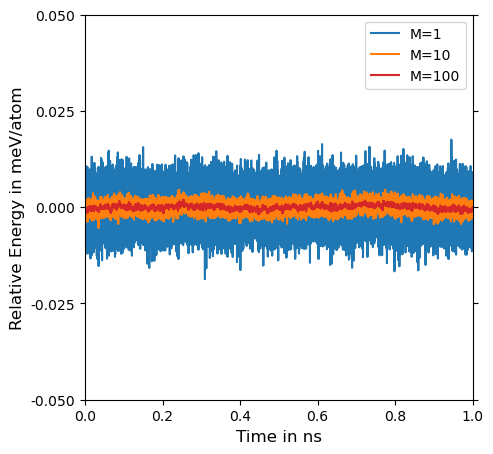

In [13]:
data = np.loadtxt("hea-nve.dat")
    
energy = (data[10000:] - np.mean(data[10000:]))
time = np.arange(len(data[10000:])) * 20.0 * 1.0 / 10**6

fig, ax = plt.subplots(figsize=(5,5))

ax.tick_params(right=True)

ylocs = [-0.050, -0.025, 0.0, 0.025, 0.050]
ylabels = ("-0.050", "-0.025", "0.000", "0.025", "0.050")

ax.set_yticks(ylocs)
ax.set_yticklabels(ylabels)

ax.set_xlim(-0.0, 1.0)
ax.set_ylim(-0.05, 0.05)

ax.plot(time, energy, label="M=1")
ax.plot(time, compute_running_average(energy, 10), label="M=10")
ax.plot(time, compute_running_average(energy, 100), color="tab:red", label="M=100")

ax.set_xlabel("Time in ns", fontsize=12)
ax.set_ylabel("Relative Energy in meV/atom", fontsize=12)
ax.legend()

plt.show()